1. Load the houseprices data from Thinkful's database.
2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
3. Now, split your data into train and test sets where 20% of the data resides in the test set.
4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
5. Evaluate your best model on the test set.
6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

### 1. Load the houseprices data from Thinkful's database.

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from scipy.stats import bartlett
from scipy.stats import levene
from statsmodels.tsa.stattools import acf
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices', con=engine)

In [3]:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


### 2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.

#### Data cleaning

In [4]:
# check for erroneous data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

Data types are in order

In [5]:
# check for missing values
df.isnull().sum().sort_values(ascending=False).head(20)

poolqc          1453
miscfeature     1406
alley           1369
fence           1179
fireplacequ      690
lotfrontage      259
garagecond        81
garagetype        81
garageyrblt       81
garagefinish      81
garagequal        81
bsmtexposure      38
bsmtfintype2      38
bsmtfintype1      37
bsmtcond          37
bsmtqual          37
masvnrarea         8
masvnrtype         8
electrical         1
utilities          0
dtype: int64

No missing values in relevant categories

#### Exploratory data analysis / more cleaning

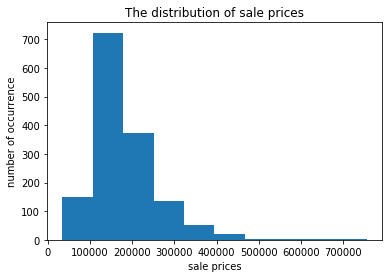

In [6]:
plt.hist(df.saleprice)
plt.title("The distribution of sale prices")
plt.xlabel("sale prices")
plt.ylabel("number of occurrence")
plt.show()

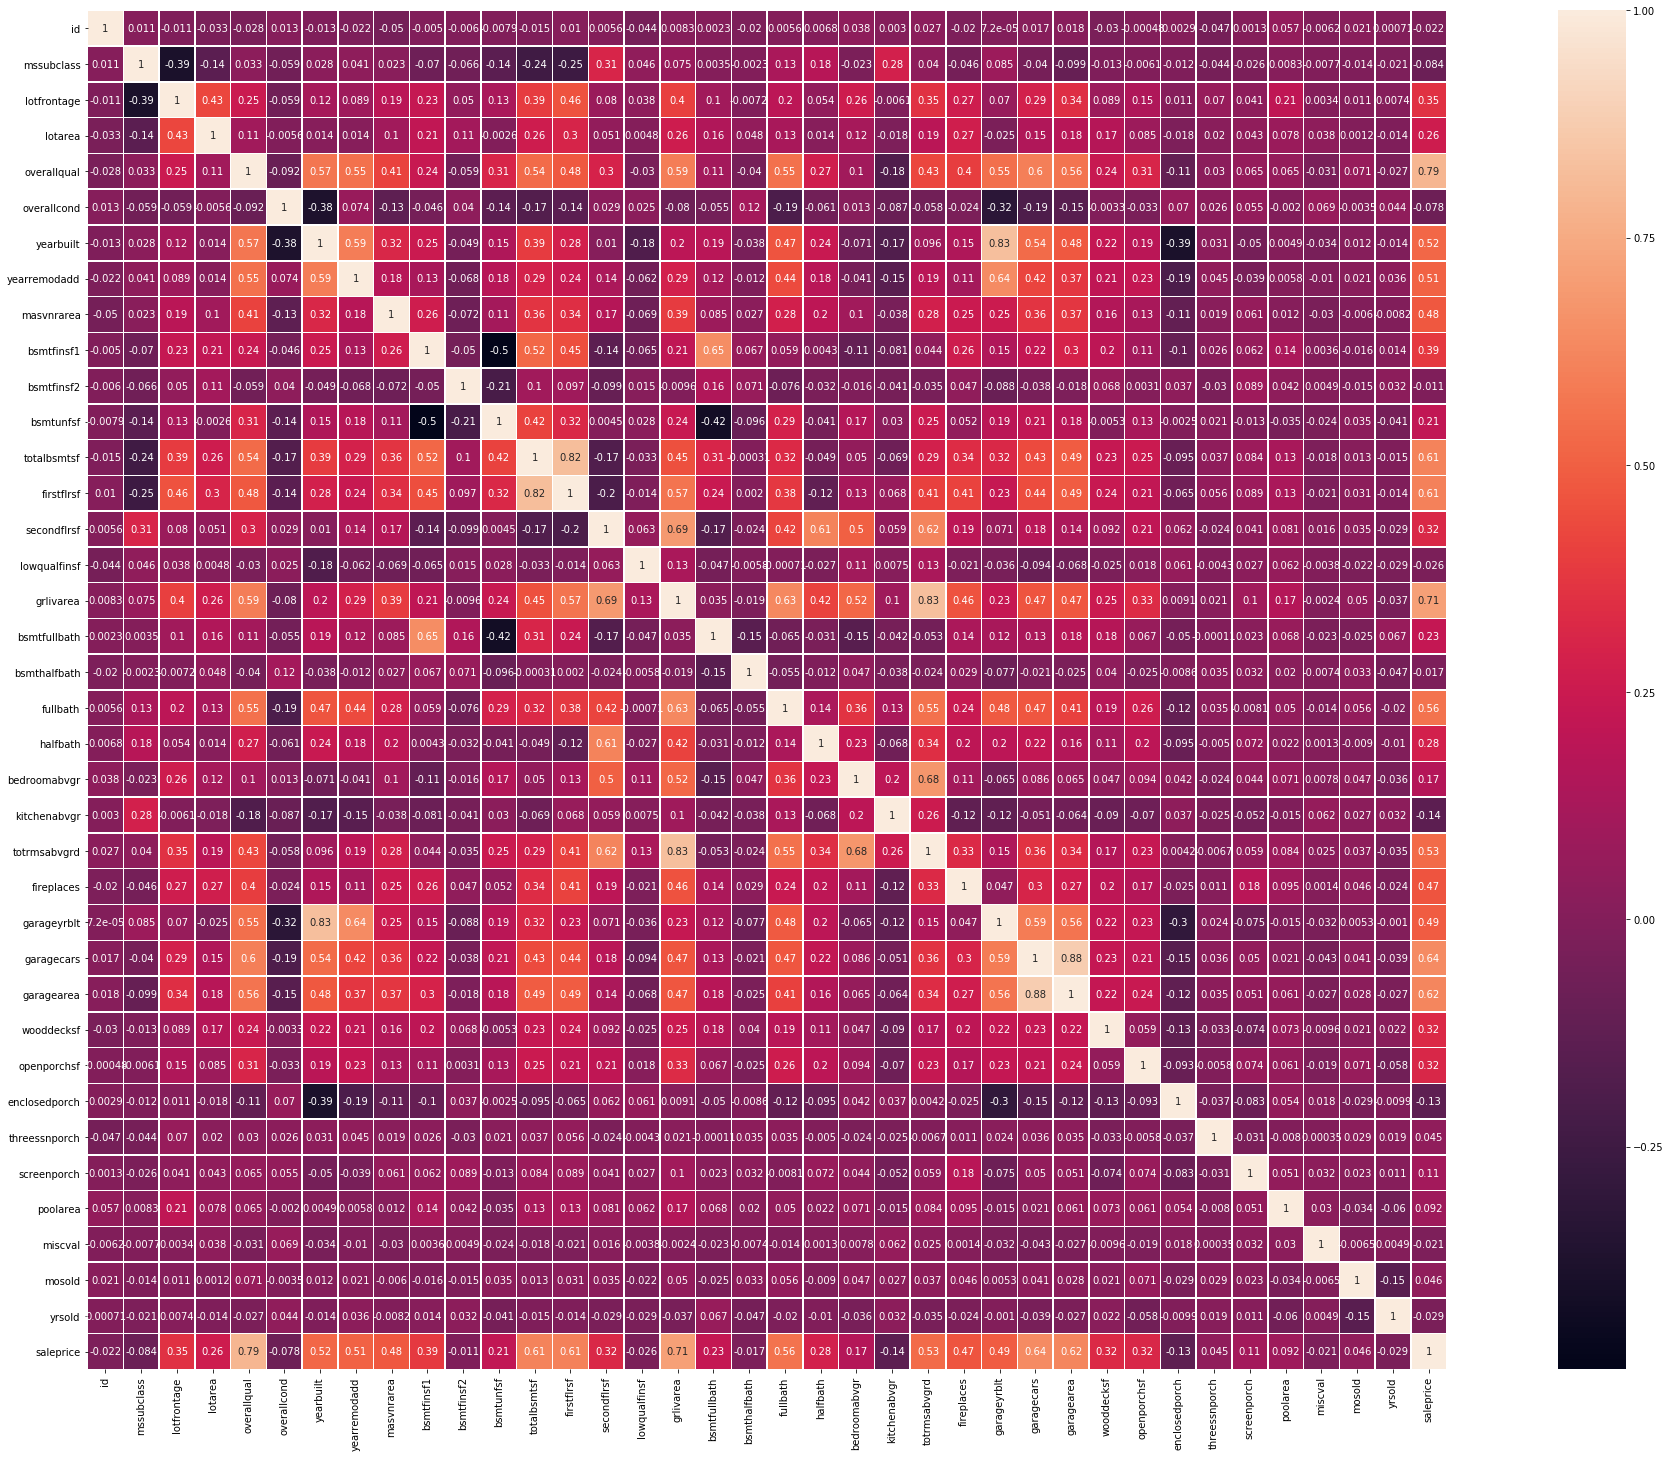

In [7]:
# produce heatmap
plt.figure(figsize=(40,25))
sns.heatmap(df.corr(), square=True, annot=True, linewidths=.5)
plt.show()

In [8]:
# 10 most correlated features 
features = ['overallqual', 'yearbuilt', 'yearremodadd', 'totalbsmtsf', 'firstflrsf', 'grlivarea', 'fullbath', 'totrmsabvgrd', 'garagecars', 'garagearea']

In [9]:
# outliers?
for col in features:
    q75, q25 = np.percentile(df[col], [75, 25])
    iqr = q75 - q25
    for threshold in np.arange(1,5,0.5):
        min_val = q25 - (iqr*threshold)
        max_val = q75 + (iqr*threshold)
        print("The score threshold is: {}".format(threshold))
        print("Number of outliers in {} is: {}".format(col,
            len((np.where((df[col] > max_val) 
                          | (df[col] < min_val))[0]))
        ))

The score threshold is: 1.0
Number of outliers in overallqual is: 23
The score threshold is: 1.5
Number of outliers in overallqual is: 2
The score threshold is: 2.0
Number of outliers in overallqual is: 0
The score threshold is: 2.5
Number of outliers in overallqual is: 0
The score threshold is: 3.0
Number of outliers in overallqual is: 0
The score threshold is: 3.5
Number of outliers in overallqual is: 0
The score threshold is: 4.0
Number of outliers in overallqual is: 0
The score threshold is: 4.5
Number of outliers in overallqual is: 0
The score threshold is: 1.0
Number of outliers in yearbuilt is: 28
The score threshold is: 1.5
Number of outliers in yearbuilt is: 7
The score threshold is: 2.0
Number of outliers in yearbuilt is: 0
The score threshold is: 2.5
Number of outliers in yearbuilt is: 0
The score threshold is: 3.0
Number of outliers in yearbuilt is: 0
The score threshold is: 3.5
Number of outliers in yearbuilt is: 0
The score threshold is: 4.0
Number of outliers in yearbuil

Text(0.5, 1.0, 'histogram of garagearea')

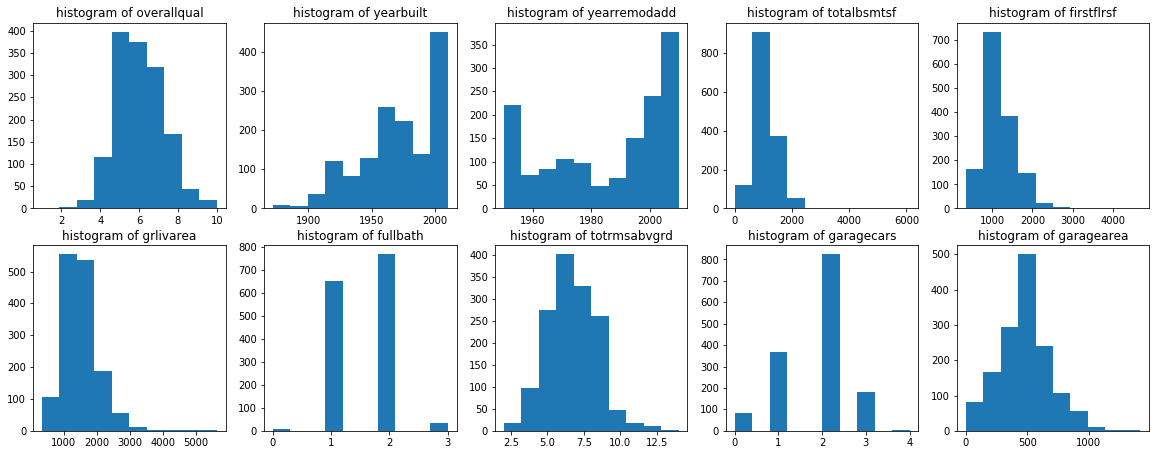

In [10]:
plt.figure(figsize=(20,7.5))

plt.subplot(251)
plt.hist(df["overallqual"])
plt.title("histogram of {}".format("overallqual"))

plt.subplot(252)
plt.hist(df["yearbuilt"])
plt.title("histogram of {}".format("yearbuilt"))

plt.subplot(253)
plt.hist(df["yearremodadd"])
plt.title("histogram of {}".format("yearremodadd"))

plt.subplot(254)
plt.hist(df["totalbsmtsf"])
plt.title("histogram of {}".format("totalbsmtsf"))

plt.subplot(255)
plt.hist(df["firstflrsf"])
plt.title("histogram of {}".format("firstflrsf"))

plt.subplot(256)
plt.hist(df["grlivarea"])
plt.title("histogram of {}".format("grlivarea"))

plt.subplot(257)
plt.hist(df["fullbath"])
plt.title("histogram of {}".format("fullbath"))

plt.subplot(258)
plt.hist(df["totrmsabvgrd"])
plt.title("histogram of {}".format("totrmsabvgrd"))

plt.subplot(259)
plt.hist(df["garagecars"])
plt.title("histogram of {}".format("garagecars"))

plt.subplot(2,5,10)
plt.hist(df["garagearea"])
plt.title("histogram of {}".format("garagearea"))

In [11]:
df2 = df.copy()

# winzorize
for col in features:
    df2.loc[:, col] = winsorize(df2.loc[:, col], (0, 0.1))

Text(0.5, 1.0, 'Winzorized')

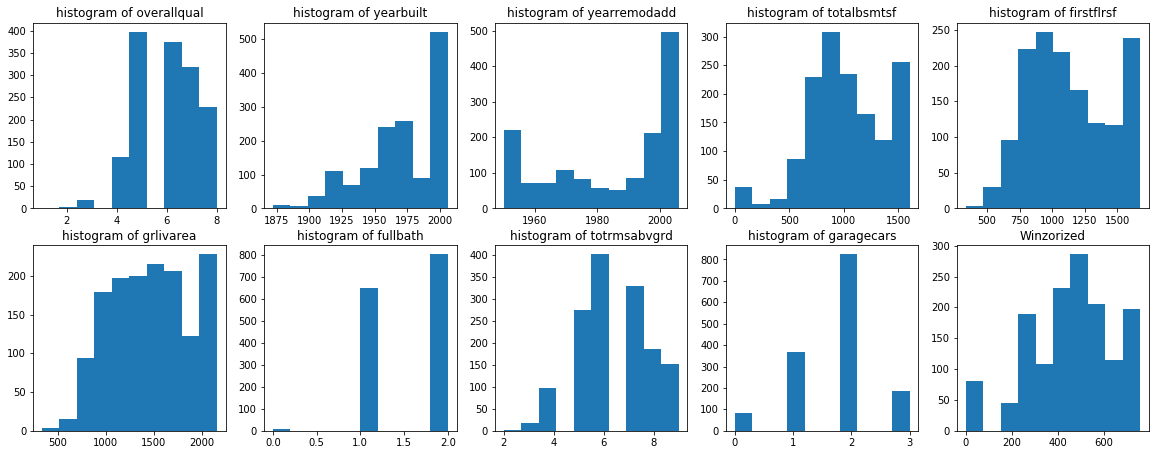

In [12]:
plt.figure(figsize=(20,7.5))

plt.subplot(251)
plt.hist(df2["overallqual"])
plt.title("histogram of {}".format("overallqual"))

plt.subplot(252)
plt.hist(df2["yearbuilt"])
plt.title("histogram of {}".format("yearbuilt"))

plt.subplot(253)
plt.hist(df2["yearremodadd"])
plt.title("histogram of {}".format("yearremodadd"))

plt.subplot(254)
plt.hist(df2["totalbsmtsf"])
plt.title("histogram of {}".format("totalbsmtsf"))

plt.subplot(255)
plt.hist(df2["firstflrsf"])
plt.title("histogram of {}".format("firstflrsf"))

plt.subplot(256)
plt.hist(df2["grlivarea"])
plt.title("histogram of {}".format("grlivarea"))

plt.subplot(257)
plt.hist(df2["fullbath"])
plt.title("histogram of {}".format("fullbath"))

plt.subplot(258)
plt.hist(df2["totrmsabvgrd"])
plt.title("histogram of {}".format("totrmsabvgrd"))

plt.subplot(259)
plt.hist(df2["garagecars"])
plt.title("histogram of {}".format("garagecars"))

plt.subplot(2,5,10)
plt.hist(df2["garagearea"])
plt.title("histogram of {}".format("garagearea"))

plt.title('Winzorized')

In [13]:
df3 = df.copy()

# square root
for col in features:
    df3.loc[:, col] = np.sqrt(df3.loc[:, col])

Text(0.5, 1.0, 'Square root')

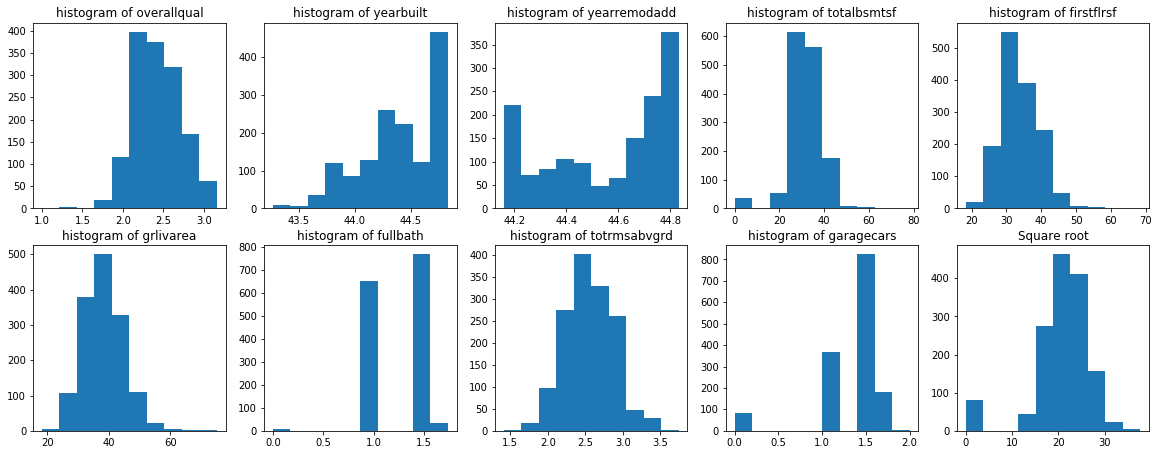

In [14]:
plt.figure(figsize=(20,7.5))

plt.subplot(251)
plt.hist(df3["overallqual"])
plt.title("histogram of {}".format("overallqual"))

plt.subplot(252)
plt.hist(df3["yearbuilt"])
plt.title("histogram of {}".format("yearbuilt"))

plt.subplot(253)
plt.hist(df3["yearremodadd"])
plt.title("histogram of {}".format("yearremodadd"))

plt.subplot(254)
plt.hist(df3["totalbsmtsf"])
plt.title("histogram of {}".format("totalbsmtsf"))

plt.subplot(255)
plt.hist(df3["firstflrsf"])
plt.title("histogram of {}".format("firstflrsf"))

plt.subplot(256)
plt.hist(df3["grlivarea"])
plt.title("histogram of {}".format("grlivarea"))

plt.subplot(257)
plt.hist(df3["fullbath"])
plt.title("histogram of {}".format("fullbath"))

plt.subplot(258)
plt.hist(df3["totrmsabvgrd"])
plt.title("histogram of {}".format("totrmsabvgrd"))

plt.subplot(259)
plt.hist(df3["garagecars"])
plt.title("histogram of {}".format("garagecars"))

plt.subplot(2,5,10)
plt.hist(df3["garagearea"])
plt.title("histogram of {}".format("garagearea"))

plt.title('Square root')

In [15]:
df4 = df.copy()

# log
for col in features:
    df4.loc[:, col] = np.log1p(df4.loc[:, col])

Text(0.5, 1.0, 'Log')

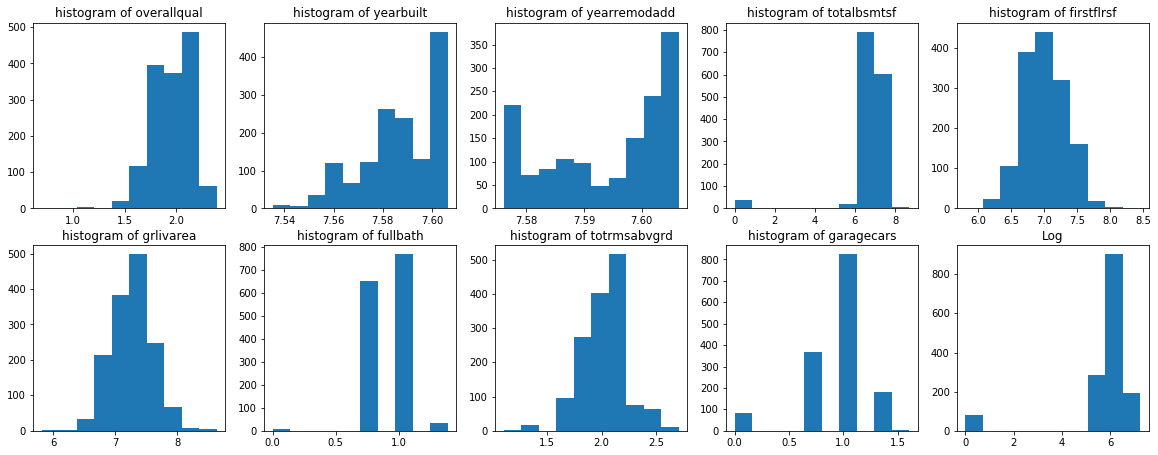

In [16]:
plt.figure(figsize=(20,7.5))

plt.subplot(251)
plt.hist(df4["overallqual"])
plt.title("histogram of {}".format("overallqual"))

plt.subplot(252)
plt.hist(df4["yearbuilt"])
plt.title("histogram of {}".format("yearbuilt"))

plt.subplot(253)
plt.hist(df4["yearremodadd"])
plt.title("histogram of {}".format("yearremodadd"))

plt.subplot(254)
plt.hist(df4["totalbsmtsf"])
plt.title("histogram of {}".format("totalbsmtsf"))

plt.subplot(255)
plt.hist(df4["firstflrsf"])
plt.title("histogram of {}".format("firstflrsf"))

plt.subplot(256)
plt.hist(df4["grlivarea"])
plt.title("histogram of {}".format("grlivarea"))

plt.subplot(257)
plt.hist(df4["fullbath"])
plt.title("histogram of {}".format("fullbath"))

plt.subplot(258)
plt.hist(df4["totrmsabvgrd"])
plt.title("histogram of {}".format("totrmsabvgrd"))

plt.subplot(259)
plt.hist(df4["garagecars"])
plt.title("histogram of {}".format("garagecars"))

plt.subplot(2,5,10)
plt.hist(df4["garagearea"])
plt.title("histogram of {}".format("garagearea"))

plt.title('Log')

In [17]:
# determine square root is the best (most normalized)
df = df3.copy()

In [18]:
# check for statistical significance

Y = df.saleprice
X = df[features]

# build OLS
X = sm.add_constant(X)
ols = sm.OLS(Y, X).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     438.3
Date:                Tue, 19 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:31:35   Log-Likelihood:                -17527.
No. Observations:                1460   AIC:                         3.508e+04
Df Residuals:                    1449   BIC:                         3.514e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3.048e+06   2.63e+05    -11.598      0.000   -3.56e+06   -2.53e+06
overallqual   8.697e+04   6035.451     14.410      0.000    7.51e+04    9.88e+04
yearbuilt     3.138e+04   4529.110      6.928      0.000    2.25e+04    4.03e+04
yearremodadd  3.062e+04   5916.912      5.174      0.000     1.9e+04    4.22e+04
totalbsmtsf    860.9967    193.836      4.442      0.000     480.768    1241.226
firstflrsf    1970.6534    289.767      6.801      0.000    1402.246    2539.061
grlivarea     4564.3366    363.258     12.565      0.000    3851.769    5276.905
fullbath     -1.842e+04   6237.744     -2.953      0.003   -3.07e+04   -6185.243
totrmsabvgrd -2876.1528   6119.621     -0.470      0.638   -1.49e+04    9128.110
garagecars    1341.8242   8385.182      0.160      0.873   -1.51e+04    1.78e+04
garagearea     852.4847    498.037      1.712      0.087    -124.466    1829.436
==============================================================================
Omnibus:                      559.661   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21885.008
Skew:                           1.080   Prob(JB):                         0.00
Kurtosis:                      21.844   Cond. No.                     2.27e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
# totrmsabvgrd, garagecars, garagearea are not statistically significant.

# remove them
#features.remove('totrmsabvgrd')
#features.remove('garagecars')
#features.remove('garagearea')
#features.remove('fullbath')

# EDIT 1A: Model performed better without above removal. left to show work

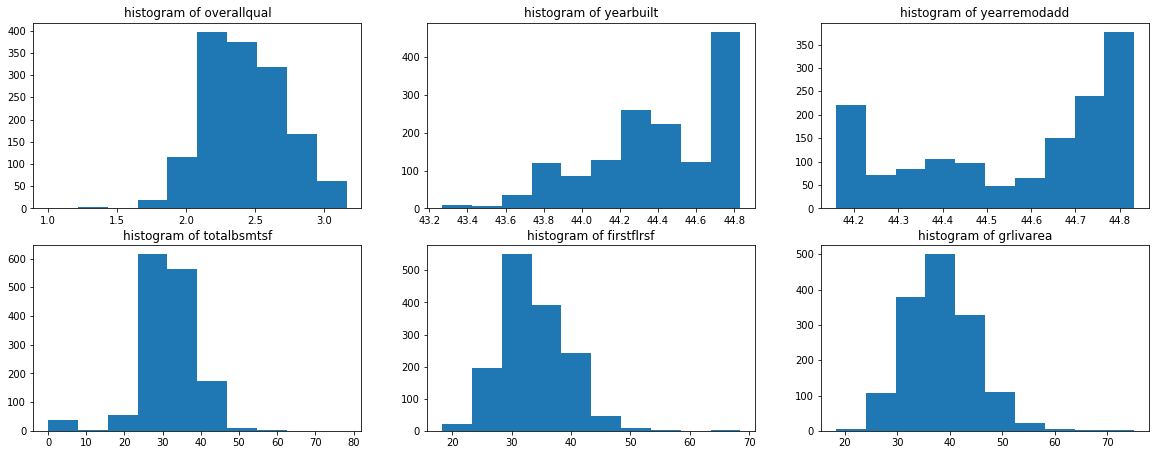

In [20]:
plt.figure(figsize=(20,7.5))

plt.subplot(231)
plt.hist(df["overallqual"])
plt.title("histogram of {}".format("overallqual"))

plt.subplot(232)
plt.hist(df["yearbuilt"])
plt.title("histogram of {}".format("yearbuilt"))

plt.subplot(233)
plt.hist(df["yearremodadd"])
plt.title("histogram of {}".format("yearremodadd"))

plt.subplot(234)
plt.hist(df["totalbsmtsf"])
plt.title("histogram of {}".format("totalbsmtsf"))

plt.subplot(235)
plt.hist(df["firstflrsf"])
plt.title("histogram of {}".format("firstflrsf"))

plt.subplot(236)
plt.hist(df["grlivarea"])
plt.title("histogram of {}".format("grlivarea"))

plt.show()

#### Feature engineering

In [21]:
features

['overallqual',
 'yearbuilt',
 'yearremodadd',
 'totalbsmtsf',
 'firstflrsf',
 'grlivarea',
 'fullbath',
 'totrmsabvgrd',
 'garagecars',
 'garagearea']

In [22]:
df2 = pd.DataFrame()

# select features for below heatmap
df2['saleprice'] = df.saleprice
df2['overallqual'] = df.overallqual
df2['yearbuilt'] = df.yearbuilt
df2['yearremodadd'] = df.yearremodadd
df2['totalbsmtsf'] = df.totalbsmtsf
df2['firstflrsf'] = df.firstflrsf
df2['grlivarea'] = df.grlivarea

# re-added (1A)
df2['fullbath'] = df.fullbath
df2['totrmsabvgrd'] = df.totrmsabvgrd
df2['garagecars'] = df.garagecars
df2['garagearea'] = df.garagearea

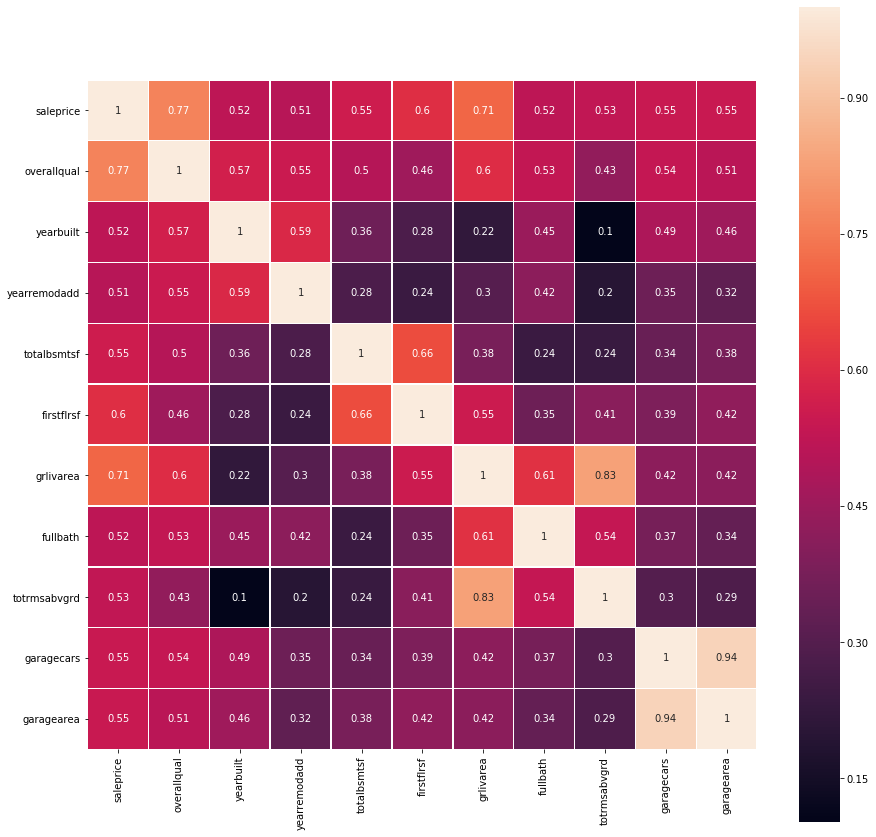

In [23]:
# produce heatmap of features in model
plt.figure(figsize=(15,15))
sns.heatmap(df2.corr(), square=True, annot=True, linewidths=.5)
plt.show()

In [24]:
# combine correlated features

df['grlivarea_totrmsabvgrd'] = df.grlivarea * df.totrmsabvgrd
features.append('grlivarea_totrmsabvgrd')
features.remove('grlivarea')
features.remove('totrmsabvgrd')

df['garagearea_garagecars'] = df.garagearea * df.garagecars
features.append('garagearea_garagecars')
features.remove('garagearea')
features.remove('garagecars')

df['totalsf'] = df.firstflrsf + df.totalbsmtsf
features.append('totalsf')
features.remove('firstflrsf')
features.remove('totalbsmtsf')

In [25]:
Y = df.saleprice
X = df[features]

X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     646.0
Date:                Tue, 19 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:31:38   Log-Likelihood:                -17511.
No. Observations:                1460   AIC:                         3.504e+04
Df Residuals:                    1452   BIC:                         3.508e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -2.697e+06   2.61e+05    -10.332      0.000   -3.21e+06   -2.19e+06
overallqual             8.789e+04   5735.848     15.323      0.000    7.66e+04    9.91e+04
yearbuilt               2.643e+04   4497.157      5.877      0.000    1.76e+04    3.53e+04
yearremodadd            2.933e+04   5839.090      5.023      0.000    1.79e+04    4.08e+04
fullbath                -1.81e+04   6082.415     -2.976      0.003      -3e+04   -6167.668
grlivarea_totrmsabvgrd   934.3325     54.013     17.298      0.000     828.381    1040.284
garagearea_garagecars    989.5856    115.238      8.587      0.000     763.535    1215.636
totalsf                 1285.4540    106.892     12.026      0.000    1075.774    1495.134
==============================================================================
Omnibus:                      554.486   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21360.693
Skew:                           1.068   Prob(JB):                         0.00
Kurtosis:                      21.616   Cond. No.                     3.55e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.55e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 3. Now, split your data into train and test sets where 20% of the data resides in the test set.

In [26]:
features

['overallqual',
 'yearbuilt',
 'yearremodadd',
 'fullbath',
 'grlivarea_totrmsabvgrd',
 'garagearea_garagecars',
 'totalsf']

In [27]:
Y = np.log1p(df.saleprice)
X = df[features]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


### 4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!

#### NOTE: Using Grid Search to select hyperparameters.

### OLS

In [29]:
X_train = sm.add_constant(X_train)
ols = sm.OLS(y_train, X_train).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     772.8
Date:                Tue, 19 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:31:39   Log-Likelihood:                 434.47
No. Observations:                1168   AIC:                            -852.9
Df Residuals:                    1160   BIC:                            -812.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -5.1270      1.260     -4.070      0.000      -7.598      -2.656
overallqual                0.4816      0.028     17.216      0.000       0.427       0.537
yearbuilt                  0.1501      0.022      6.964      0.000       0.108       0.192
yearremodadd               0.1883      0.028      6.744      0.000       0.134       0.243
fullbath                  -0.0227      0.029     -0.775      0.439      -0.080       0.035
grlivarea_totrmsabvgrd     0.0040      0.000     15.477      0.000       0.004       0.005
garagearea_garagecars      0.0052      0.001      9.615      0.000       0.004       0.006
totalsf                    0.0060      0.001     11.937      0.000       0.005       0.007
==============================================================================
Omnibus:                      594.189   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11286.031
Skew:                          -1.898   Prob(JB):                         0.00
Kurtosis:                      17.748   Cond. No.                     3.59e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Lasso

In [30]:
# test parameters
parameter_candidates = [
  {'alpha': [.00001, .0001, .0004, .0005, .0006, .001, .01, .025, .05, .075, .125, .25, .5, 1, 10, 10**2, 10**3, 10**4, 10**5]}
]

In [31]:
# Create a classifier object with the classifier and parameter candidates
clf = GridSearchCV(estimator=Lasso(), param_grid=parameter_candidates, n_jobs=-1)

# Train the classifier on data1's feature and target data
clf.fit(X_train, y_train)   

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'alpha': [1e-05, 0.0001, 0.0004, 0.0005, 0.0006,
                                    0.001, 0.01, 0.025, 0.05, 0.075, 0.125,
                                    0.25, 0.5, 1, 10, 100, 1000, 10000,
                                    100000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [32]:
# View the accuracy score
print('Best score for data1:', clf.best_score_) 

Best score for data1: 0.8152610503566613


In [33]:
# View the best parameters for the model found using grid search
print('Best Alpha:',clf.best_estimator_.alpha) 

Best Alpha: 0.0005


In [34]:
lasso_cv = Lasso(alpha=.0005).fit(X_train, y_train) 

print("R-squared of the Lasso model on the training set is: {}".format(lasso_cv.score(X_train, y_train)))

R-squared of the Lasso model on the training set is: 0.8232825361464988


### Ridge

In [35]:
# test parameters
parameter_candidates = [
  {'alpha': [.00001, .0001, .001, .01, .025, .05, .075, .125, .25, .3, .35, .4, .45, .5, .6, 1, 10, 10**2, 10**3, 10**4, 10**5]}
]

In [ ]:
# Create a classifier object with the classifier and parameter candidates
clf = GridSearchCV(estimator=Ridge(), param_grid=parameter_candidates, n_jobs=-1)

# Train the classifier on data1's feature and target data
clf.fit(X_train, y_train)  

In [ ]:
# View the accuracy score
print('Best score for data1:', clf.best_score_) 

In [ ]:
# View the best parameters for the model found using grid search
print('Best Alpha:', clf.best_estimator_.alpha) 

In [ ]:
ridge_cv = Ridge(alpha=.4).fit(X_train, y_train)

print("R-squared of the Ridge model on the training set is: {}".format(ridge_cv.score(X_train, y_train)))

### ElasticNet

In [ ]:
parameter_candidates = [
  {'alpha': [.00001, .0001, .0005, .001, .005, .01, .025, .05, .075, .125, .25, .3, .35, .4, .45, .5, .6, 1, 10, 10**2, 10**3, 10**4, 10**5],
   'l1_ratio': [.00001, .0001, .001, .01, .025, .05, .075, .125, .25, .3, .35, .4, .425, .45, .475, .5, .6, 10, 10**2, 10**3, 10**4, 10**5]}
]

In [ ]:
# Create a classifier object with the classifier and parameter candidates
clf = GridSearchCV(estimator=ElasticNet(), param_grid=parameter_candidates, n_jobs=-1)

# Train the classifier on data1's feature and target data
clf.fit(X_train, y_train)

In [ ]:
# View the accuracy score
print('Best score for data1:', clf.best_score_) 

In [ ]:
# View the best parameters for the model found using grid search
print('Best Alpha:',clf.best_estimator_.alpha)
print('Best L1 Ratio:',clf.best_estimator_.l1_ratio)

In [ ]:
elastic_cv = ElasticNet(alpha=.0005, l1_ratio=.6).fit(X_train, y_train)

print("R-squared of the ElasticNet model on the training set is: {}".format(elastic_cv.score(X_train, y_train)))

### 5. Evaluate your best model on the test set.

In [ ]:
# ridge was the best model

# add constant
X_test = sm.add_constant(X_test)

# making predictions
y_preds_test = ridge_cv.predict(X_test)

# plot
plt.scatter(y_test, y_preds_test, c='black', label='datapoints')
plt.plot(y_test, y_test, c='blue', label='ideal line')
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title('Ridge: Alpha=0.4')
plt.legend()
plt.show()

# evaluate 
print("R-squared of the model on the test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

### 6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

In [ ]:
# federal reserve interest rates
# https://www.kaggle.com/federalreserve/interest-rates
ir = pd.read_csv('interest_rates.csv')

In [ ]:
ir.head()

In [ ]:
rates = ir.groupby(['Year']).mean()['Effective Federal Funds Rate']
rates = rates.to_frame()
rates.head()

In [ ]:
df3 = pd.read_sql_query('select * from houseprices', con=engine)
df3.head()

In [ ]:
df3[['yearremodadd']].head()

In [ ]:
#df4 = pd.merge(left=df2, right=rates, left_on='yearbuilt', right_on='Year')
df4 = pd.merge(left=df3, right=rates, left_on='yearremodadd', right_on='Year')

In [ ]:
df4[['yearremodadd', 'Effective Federal Funds Rate']]

In [ ]:
features.append('Effective Federal Funds Rate')

In [ ]:
features

In [ ]:
# produce heatmap
plt.figure(figsize=(40,25))
sns.heatmap(df4.corr(), square=True, annot=True, linewidths=.5)
plt.show()

We see that the effective federal funds rate has little correlation to sale price. We should not add it to our model.

Let's confirm this just because.

In [ ]:
# restore features from previous model
df4['grlivarea_totrmsabvgrd'] = df.grlivarea * df.totrmsabvgrd
df4['garagearea_garagecars'] = df.garagearea * df.garagecars
df4['totalsf'] = df.firstflrsf + df.totalbsmtsf

In [ ]:
Y = df4.saleprice
X = df4[features]

X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()
results.summary()

As we can see, the adjusted R-squared score lowered from 756 to 635, confirming that this model is worse.